In [ ]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

# Simulação

## Email de doações

In [ ]:
years= ["2014", "2015", "2016", "2017", "2018"]
memberStatus= ["bronze", "silver", "gold", "inactive"]

memberYears= np.random.choice(years, 1000, p= [0.1, 0.1, 0.15, 0.3, 0.35])
memberStats= np.random.choice(memberStatus, 1000, p= [0.5, 0.3, 0.1, 0.1])

yearJoined= pd.DataFrame({"yearJoined": memberYears,
                          "memberStats": memberStats})

yearJoined.head()

,yearJoined,memberStats
0,2016,silver
1,2016,bronze
2,2018,bronze
3,2017,bronze
4,2016,silver


In [ ]:
NUM_EMAILS_SENT_WEEKLY= 3

def never_opens(period_rng):
  return []

def constant_open_rate(period_rng):
  n, p = NUM_EMAILS_SENT_WEEKLY, np.random.uniform(0, 1)
  num_opened = np.random.binomial(n, p, len(period_rng))
  return num_opened

def increasing_open_rate(period_rng):
  return open_rate_with_factor_change(period_rng,
                                       np.random.uniform(1.01,
                                                         1.30))

def decreasing_open_rate(period_rng):
  return open_rate_with_factor_change(period_rng,
                                       np.random.uniform(0.5,
                                                         0.99))

def open_rate_with_factor_change(period_rng, fac):
    if len(period_rng) < 1 :
        return []
    times = np.random.randint(0, len(period_rng),
                               int(0.1 * len(period_rng)))
    num_opened = np.zeros(len(period_rng))
    for prd in range(0, len(period_rng), 2):
        try:
            n, p = NUM_EMAILS_SENT_WEEKLY, np.random.uniform(0,
                                                             1)
            num_opened[prd:(prd + 2)] = np.random.binomial(n, p,
                                                           2)
            p = max(min(1, p * fac), 0)
        except:
            num_opened[prd] = np.random.binomial(n, p, 1)
    for t in range(len(times)):
        num_opened[times[t]] = 0
    return num_opened

def produce_donations(period_rng, member_behavior, num_emails,
                      use_id, member_join_year):
    donation_amounts = np.array([0, 25, 50, 75, 100, 250, 500,
                                 1000, 1500, 2000])
    member_has = np.random.choice(donation_amounts)
    email_fraction = num_emails  / (NUM_EMAILS_SENT_WEEKLY * len(period_rng))
    member_gives = member_has * email_fraction
    member_gives_idx = np.where(member_gives
                                 >= donation_amounts)[0][-1]
    member_gives_idx = max(min(member_gives_idx,
                               len(donation_amounts) - 2),
                           1)
    num_times_gave = np.random.poisson(2) * (2018 - member_join_year)
    times = np.random.randint(0, len(period_rng), num_times_gave)
    dons = pd.DataFrame({'member'   : [],
                         'amount'   : [],
                         'timestamp': []})

    for n in range(num_times_gave):
        donation = donation_amounts[member_gives_idx
                     + np.random.binomial(1, .3)]
        ts = str(period_rng[times[n]]
                  + random_weekly_time_delta())
        dons = dons.append(pd.DataFrame(
                  {'member'   : [use_id],
                   'amount'   : [donation],
                   'timestamp': [ts]}))

    if dons.shape[0] > 0:
        dons = dons[dons.amount != 0]
        ## we don't report zero donation events as this would not
        ## be recorded in a real world database
    return dons


def random_weekly_time_delta():
    days_of_week = [d for d in range(7)]
    hours_of_day = [h for h in range(11, 23)]
    minute_of_hour = [m for m in range(60)]
    second_of_minute = [s for s in range(60)]

    return pd.Timedelta(str(np.random.choice(days_of_week)) + " days" ) + pd.Timedelta(str(np.random.choice(hours_of_day)) + " hours" ) + pd.Timedelta(str(np.random.choice(minute_of_hour)) + " minutes") + pd.Timedelta(str(np.random.choice(second_of_minute)) + " seconds")

In [ ]:
## python
behaviors = [never_opens,
             constant_open_rate,
             increasing_open_rate,
              decreasing_open_rate]
member_behaviors = np.random.choice(behaviors, 1000,
                                   [0.2, 0.5, 0.1, 0.2])

rng = pd.period_range('2015-02-14', '2018-06-01', freq = 'W').to_timestamp()
emails = pd.DataFrame({'member'      : [],
                       'week'        : [],
                       'emailsOpened': []})
donations = pd.DataFrame({'member'   : [],
                          'amount'   : [],
                          'timestamp': []})

for idx in range(yearJoined.shape[0]):
    ## randomly generate the date when a member would have joined
    join_date = pd.Timestamp(yearJoined.iloc[idx].yearJoined) + pd.Timedelta(str(np.random.randint(0, 365)) +  ' days')
    join_date = min(join_date, pd.Timestamp('2018-06-01'))

    ## member should not have action timestamps before joining
    member_rng = rng[rng > join_date]

    if len(member_rng) < 1:
        continue

    info = member_behaviors[idx](member_rng)
    if len(info) == len(member_rng):
        emails = emails.append(pd.DataFrame(
           {'member': [idx] * len(info),
            'week': [str(r) for r in member_rng],
            'emailsOpened': info}))
        donations = donations.append(
           produce_donations(member_rng, member_behaviors[idx],
                                sum(info), idx, join_date.year))

<Axes: xlabel='timestamp'>

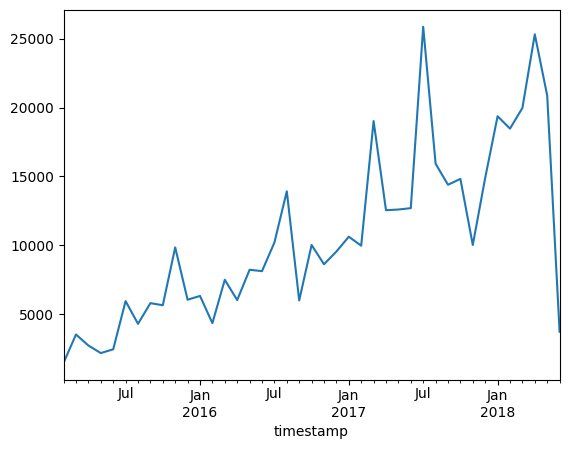

In [ ]:
donations.set_index(pd.to_datetime(donations.timestamp), inplace = True)
donations.sort_index(inplace = True)
donations.groupby(pd.Grouper(freq='M')).amount.sum().plot()

## Construindo um universo de simulação autogerido

In [ ]:
# função geradora: gera objetos de uso unico, todos independentes uns dos outros, mantendo seu propeio estado
def taxi_id_number(num_taxis):
  arr= np.arange(num_taxis)
  np.random.shuffle(arr)
  for i in range(num_taxis):
    yield arr[i]

ids = taxi_id_number(10)
print(next(ids))
print(next(ids))
print(next(ids))
print(next(ids))

8
1
0
7


In [ ]:
def shift_info():
  start_times_and_freqs= [(0,8), (8,30), (16,15)]
  indices= np.arange(len(start_times_and_freqs))

  while True:
    idx= np.random.choice(indices, p=  [ 0.25, 0.5, 0.25])
    start= start_times_and_freqs[idx]
    yield(start[0], start[0] + 7.5, start[1])

In [ ]:
from dataclasses import dataclass

@dataclass
class TimePoint:
   taxi_id:    int
   name: str
   time: float

   def __lt__(self, other):
       return self.time < other.time

In [ ]:
def taxi_process(taxi_id_generator, shift_info_generator):
   taxi_id = next(taxi_id_generator)
   shift_start, shift_end, shift_mean_trips = next(shift_info_generator)
   actual_trips = round(np.random.normal(loc = shift_mean_trips, scale = 2))
   average_trip_time = 6.5 / shift_mean_trips * 60

   # convert mean trip time to minutes
   between_events_time = 1.0 / (shift_mean_trips - 1) * 60

   # this is an efficient city where cabs are seldom unused
   time = shift_start
   yield TimePoint(taxi_id, 'start shift', time)
   deltaT = np.random.poisson(between_events_time) / 60
   time += deltaT
   for i in range(actual_trips):
       yield TimePoint(taxi_id, 'pick up    ', time)
       deltaT = np.random.poisson(average_trip_time) / 60
       time += deltaT
       yield TimePoint(taxi_id, 'drop off   ', time)
       deltaT = np.random.poisson(between_events_time) / 60
       time += deltaT
   deltaT = np.random.poisson(between_events_time) / 60
   time += deltaT
   yield TimePoint(taxi_id, 'end shift  ', time)

In [ ]:
import queue

class Simulator:
   def __init__(self, num_taxis):
       self._time_points = queue.PriorityQueue()
       taxi_id_generator = taxi_id_number(num_taxis)
       shift_info_generator = shift_info()
       self._taxis = [taxi_process(taxi_id_generator,
                                   shift_info_generator) for
                                            i in range(num_taxis)]
       self._prepare_run()

   def _prepare_run(self):
       for t in self._taxis:
           while True:
               try:
                   e = next(t)
                   self._time_points.put(e)
               except:
                   break

   def run(self):
       sim_time = 0
       while sim_time < 24:
           if self._time_points.empty():
               break
           p = self._time_points.get()
           sim_time = p.time
           print(p)

In [ ]:
sim= Simulator(1000)
sim.run()

A saída de streaming foi truncada nas últimas 5000 linhas.
TimePoint(taxi_id=98, name='pick up    ', time=17.93333333333334)
TimePoint(taxi_id=480, name='drop off   ', time=17.95)
TimePoint(taxi_id=19, name='drop off   ', time=17.95)
TimePoint(taxi_id=140, name='pick up    ', time=17.95)
TimePoint(taxi_id=493, name='drop off   ', time=17.95)
TimePoint(taxi_id=955, name='pick up    ', time=17.95)
TimePoint(taxi_id=987, name='pick up    ', time=17.95)
TimePoint(taxi_id=139, name='drop off   ', time=17.95)
TimePoint(taxi_id=328, name='drop off   ', time=17.95)
TimePoint(taxi_id=116, name='pick up    ', time=17.950000000000003)
TimePoint(taxi_id=551, name='pick up    ', time=17.950000000000003)
TimePoint(taxi_id=801, name='drop off   ', time=17.950000000000003)
TimePoint(taxi_id=557, name='drop off   ', time=17.950000000000003)
TimePoint(taxi_id=520, name='pick up    ', time=17.950000000000003)
TimePoint(taxi_id=367, name='drop off   ', time=17.950000000000003)
TimePoint(taxi_id=867, name=

##Simulação das Leis da Fisica

In [ ]:
# Config
N           = 5 # width of lattice
M           = 5 # height of lattice
temperature = 0.5
BETA        = 1 / temperature
print(BETA)

2.0


In [ ]:
# inicialização aleatoria
def initRandState(N, M):
    block = np.random.choice([-1, 1], size = (N, M))
    return block

In [ ]:
def costForCenterState(state, i, j, n, m):
    centerS = state[i, j]
    neighbors = [((i + 1) % n, j), ((i - 1) % n, j),
                 (i, (j + 1) % m), (i, (j - 1) % m)]

    interactionE = [state[x, y] * centerS for (x, y) in neighbors]
    return np.sum(interactionE)


def magnetizationForState(state):
    return np.sum(state)

In [ ]:
# passo do monte carlo e cadeias de markov (MCMC)
def mcmcAdjust(state):
    n = state.shape[0]
    m = state.shape[1]
    x, y = np.random.randint(0, n), np.random.randint(0, m)
    centerS = state[x, y]
    cost = costForCenterState(state, x, y, n, m)
    if cost < 0:
        centerS *= -1
    elif np.random.random() < np.exp(-cost * BETA):
        centerS *= -1
    state[x, y] = centerS
    return state

def runState(state, n_steps, snapsteps = None):
    if snapsteps is None:
        snapsteps = np.linspace(0, n_steps, num = round(n_steps / (M * N * 100)), dtype = np.int32)
    saved_states = []
    sp = 0
    magnet_hist = []
    for i in range(n_steps):
        state = mcmcAdjust(state)
        magnet_hist.append(magnetizationForState(state))
        if sp < len(snapsteps) and i == snapsteps[sp]:
            saved_states.append(np.copy(state))
            sp += 1
    return state, saved_states, magnet_hist

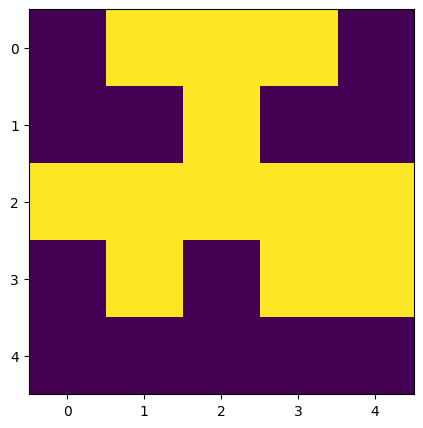

In [ ]:
init_state = initRandState(N, M)
plt.imshow(init_state)

In [ ]:
final_state, states, magnet_hist = runState(init_state, 1000)

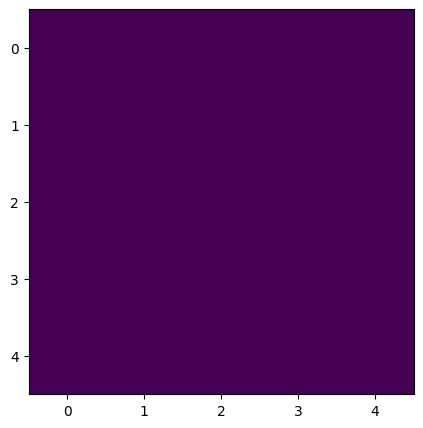

In [ ]:
plt.imshow(final_state)

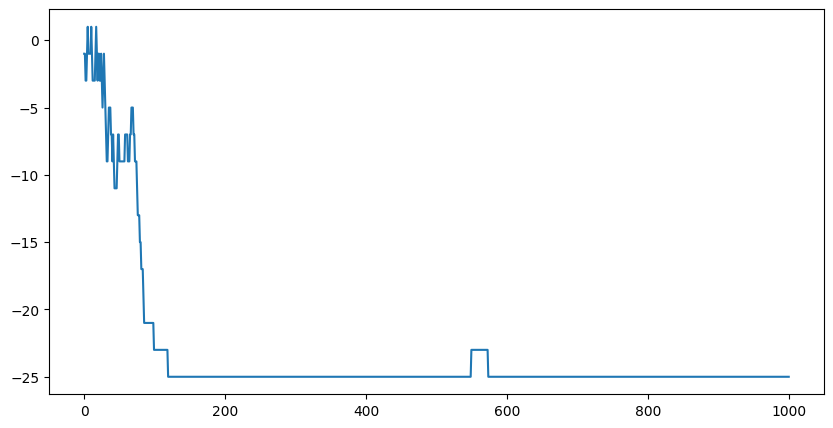

In [ ]:
plt.plot(magnet_hist)